# Attention Is All You Need

In December of 2016, Google Brains team came up with a new way to model sequences called Transformers presented in their paper <a href=https://arxiv.org/abs/1706.03762>Attention is all you need</a>. The impact of this paper continues as most Language models use this approach including some of the industry favorites like BERT and GPT-2.

Below is the basic architecture of the model presented in the paper, and the one we will try implementing.

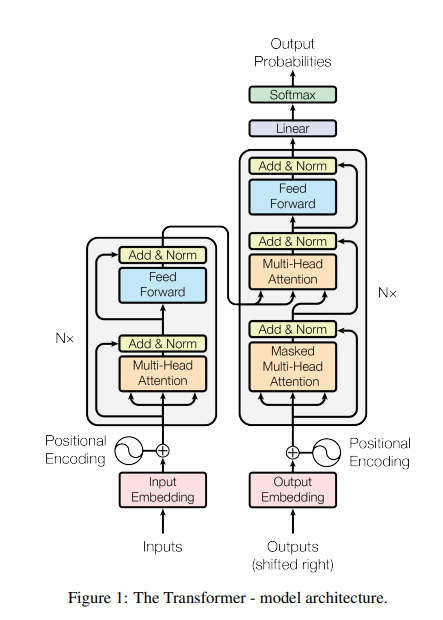

# Introduction

Until now the dominant model design has been based on RNN’s and CNN’s where model has an encoder followed by a decoder. Some models also use attention layers in between. The problem with these approaches is that they often compress the information available into a context vector along with attention vector. This method can very ineffective for long range sequences. Below is a table showing the differences between some of the language modeling approch. Source: <a href= https://deepmind.com/learning-resources/deep-learning-lecture-series-2020>DeepMind</a>

<img src="images/seq2pic.jpg" width="1000" height="400">

# Data Preperation

In [2]:
# import packages needed
import torch
import torch.nn as nn

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import numpy as np
import spacy

import random
import math
import time

In [3]:
# Set random SEED to make the results reproducable
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We will use spacy for tokenizer, before the exectuion of below line make sure to download the NLP packages using command line.
```shell
python -m spacy download de_core_news_sm
python -m spacy downlaod en_core_web_sm
```

In [4]:
spacy_de = spacy.load("de_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

In [5]:
def tokenize_de(sen:str)->list:
    """
    Tokenize the sentence and return a list.
    """
    return [tok.text for tok in spacy_de.tokenizer(sen)]

def tokenize_en(sen:str)->list:
    """
    Tokenize the sentence and return a list.
    """
    return [tok.text for tok in spacy_en.tokenizer(sen)]

<b>Note:</b> We wont be doing any stop word removel or n-gram building as we want our model to learn using all the elements in the language.

In [6]:
TRG = Field(tokenize=tokenize_de,
           init_token="<sos>",
           eos_token="<eos>",
           lower=True,
           batch_first=True)

SRC = Field(tokenize=tokenize_en,
           init_token="<sos>",
           eos_token="<eos>",
           lower=True,
           batch_first=True)

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts=(".de", ".en"),
                                                    fields=(TRG, SRC))

In [8]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(datasets=(train_data, valid_data, test_data),
                                                                      batch_size=BATCH_SIZE,
                                                                      device=device)

In [10]:
print("Sample Data")
print("SRC: "," ".join(vars(train_data.examples[0])['src']))
print("TRG: "," ".join(vars(train_data.examples[0])['trg']))

Sample Data
SRC:  zwei junge weiße männer sind im freien in der nähe vieler büsche .
TRG:  two young , white males are outside near many bushes .


# Building the Model

We will build our model in 3 parts <b>Encoder</b>, <b>Decoder</b> and <b>Attention</b>. Finally we will put all of them together into a single <b>Seq2Seq</b> Model.

## Encoder

The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, positionwise fully connected feed-forward network. We employ a residual connection around each of
the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is
LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.

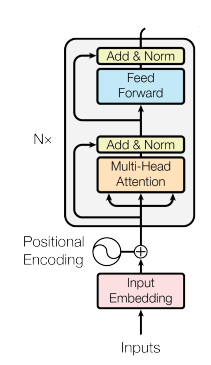

The input tokens pass through the token embedding layer and as the model does not use a recurrent layer it uses the positional embeddings to get the positional information on the tokens, these two are added together. The positional embedding layer does not concerns with the tokens but the position of the token. We have defined a max length of 100 tokens for these embedding layers.

The results from token embeddings and postional embeddings are summed elementwise and the resulting vector is then scaled $\sqrt(d$<sub>model</sub>$)$. where <i>d<sub>model</sub></i> is the hidden dimension of the model. The scaling is done to reduce the variance in the embedding vector as it makes it diffcult for model to train. The dropout is applied on the final embedding vector.

The embedding vector is applied through N encoding layers to get the final context vector which is used by the decoder. The src_mask is similar to src vector, it contains 1 when token is not $<pad>$ and 0 otherwise, this is done to avoid attention layer from focusing on the token.

In [12]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim:int,
                 hid_dim:int,
                 pf_dim:int,
                 n_layers:int,
                 n_heads:int,
                 dropout:float,
                 device:torch.device,
                 maxlen:int=100, **kwargs)->None:
        super().__init__(**kwargs)
        self.device = device
        
        self.tok_embeddings = nn.Embedding(input_dim, hid_dim)
        self.pos_embeddings = nn.Embedding(max_len, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, pf_dim, n_heads, dropout, device) for _ in range(n_layers)])
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(src:torch.tensor, src_mask:torch.tensor)->torch.tensor:
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsquezze(0).repeat(batch_size, 1).to(self.device)
        
        src = self.dropout((self.tok_embeddings(src) * self.scale)) + self.pos_embeddings(pos)
        
        for layer in self.layers:
            src = layer(src, src_mask)
        
        return src

### Encoder Layer

The encoder is made of 6 similar encoder layers, so we have absracted the details into a seperate module, this module can then be repeated N times to build the encoder.

Initially the embedding vector is passed through Multi-Head Attention layer and the passed through dropout layer, the result along with residual connection are elementwise summed and passed through layer normalization. The Multi-Head-Attention is passed the source sentence as the <b>key</b>, <b>value</b> and <b>query</b> (more on that later), this is done so that attention network will attend to the source sentence itself, therefore the name Self-Attention.

The resulting vector is then passed through positionwise feedforward network and along then normalization layer along with its residual connection. The results are then passed on to the next layer.

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim:int,
                 pf_dim:int,
                 n_head:int,
                 dropout:float,
                 device:torch.device,
                 **kwargs)->None:
        super().__init__(**kwargs)
        
        self.device = device
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionWiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src:torch.tensor, src_mas:torch.tensor)->torch.tensor:
        _src,_ = self.self_attention(src, src, src, src_mask)
        
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        _src = self.positionwise_feedforward(src)
        
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        return src

### Multi - Head Attention

One of the most groudbreaking ideas introduced in the paper is the idea of using self-attention layers to learn long term dependecies in the sequences.

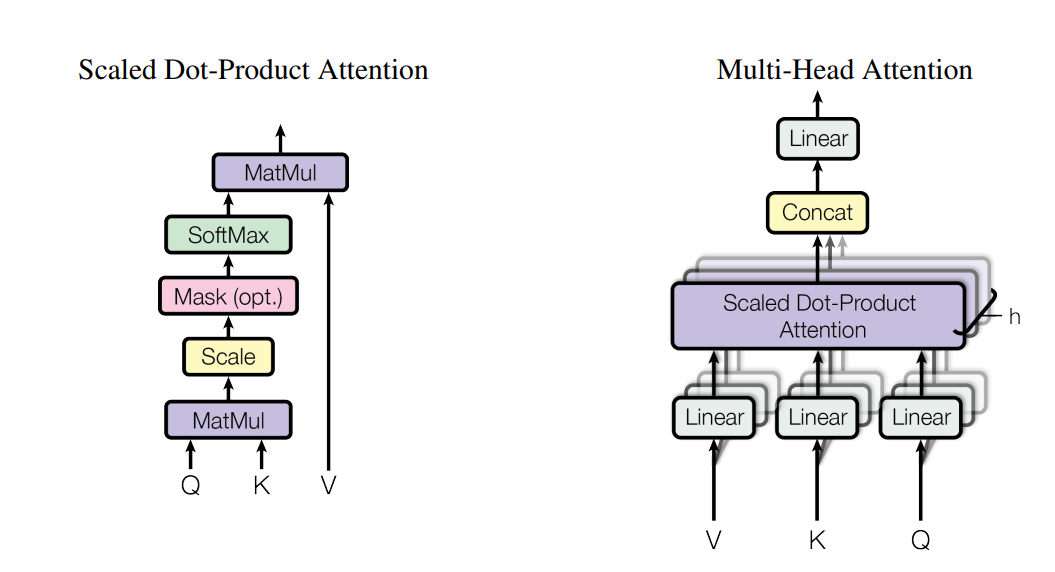

A single attention head takes 3 values a input namely Query(Q), Key(K) and Value(V). One can think of attention as a function which maps given Query to Key-Value pairs, and the corroponding result can be thought of as weighted values that describes which key-value pair is more important to query, the values sum up to 1.

We initially take the dot product of Q and K, which is then scaled to avoid the result becoming to large and making gradient zero. We then take a elementwise product with the mask <i>(optional)</i> to nullify the impact of $<pad>$ token in the final result. Softmax function is then applied on the vector before taking a dot product with V.

\begin{equation*}
Attention(Q, K, V) = Softmax\left(\frac{QK^T} {\sqrt{d_k}}\right)
\end{equation*}